In [9]:
# Load libraries
from collections import namedtuple

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot
mpl.pyplot.style.use('default')
import pandas as pd

import sklearn.preprocessing as pp
import sklearn.model_selection as ms
import sklearn.linear_model as lm
import sklearn.discriminant_analysis as da
import sklearn.tree as tr
import sklearn.neighbors as nbr
import sklearn.svm as svm
import sklearn.pipeline as pl
import sklearn.ensemble as en
import sklearn.metrics as metrics
import sklearn.utils as utils

import multiprocessing

import graphviz

import keras
import keras.layers as kl
import keras.models as km

max_procs = multiprocessing.cpu_count() - 1
pd.set_option('precision', 2)

def scaled_pipeline(arg1=None, arg2=None):
    if arg2 is None:
        model = arg1
        return pl.Pipeline([('Scaler', pp.StandardScaler()), ("Model", model)])
    else:
        name, model = arg1, arg2
        return "scaled_%s" % (name,), pl.Pipeline([('Scaler', pp.StandardScaler()), (name, model)]) 
    
def scale(matrix):
    scaler = pp.MinMaxScaler()
    result = scaler.fit_transform(matrix)
    return (scaler, result)

def binarise(matrix):
    binariser = pp.LabelBinarizer()
    result = binariser.fit_transform(matrix)
    return (binariser, result)

In [37]:
dataset = pd.read_csv('poker-hand-training-balanced+.csv').drop(['index'], axis=1)
print(dataset.columns)
print(dataset.shape)
dataset.head()

Index(['suit1', 'rank1', 'suit2', 'rank2', 'suit3', 'rank3', 'suit4', 'rank4',
       'suit5', 'rank5', 'max_rank', 'min_rank', 'n_hearts', 'n_spades',
       'n_diamonds', 'n_clubs', 'max_same_suit', 'n_aces', 'n_2s', 'n_3s',
       'n_4s', 'n_5s', 'n_6s', 'n_7s', 'n_8s', 'n_9s', 'n_10s', 'n_jacks',
       'n_queens', 'n_kings', 'max_same_rank', 'longest_contigue_seq',
       'class'],
      dtype='object')
(25010, 33)


suit1  rank1  suit2  rank2  suit3  rank3  suit4  rank4  suit5  rank5  ...  \
0      3     13      4      8      4      2      3     11      1     13  ...   
1      4     13      4     10      4      1      4     11      4     12  ...   
2      1     11      3     12      2     11      4      8      3     11  ...   
3      1      3      2     12      4     11      4      9      2      3  ...   
4      1      8      3      8      4      8      1     12      2      8  ...   

   n_7s  n_8s  n_9s  n_10s  n_jacks  n_queens  n_kings  max_same_rank  \
0     0     1     0      0        1         0        2              2   
1     0     0     0      1        1         1        1              1   
2     0     1     0      0        3         1        0              3   
3     0     0     1      0        1         1        0              2   
4     0     4     0      0        0         1        0              4   

   longest_contigue_seq  class  
0                     1      1  
1                     1      9  
2                     2      3  
3                     2      1  
4                     1      7  

[5 rows x 33 columns]

In [72]:
XY = dataset.values
X_scaler, X = scale(XY[:, :-1])
Y_binariser = pp.LabelBinarizer()
Y = XY[:, -1:]
Y_binariser.fit(Y)
print(X.shape)
print(Y.shape)
# Y = dataset[['class']]
# X = dataset[dataset.columns[:-1]]
# print(X.shape)
# print(Y.shape)

(25010, 32)
(25010, 1)


D:\Programs\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [67]:
input_size, output_size = X.shape[1], Y.shape[1]

In [32]:
class StopCallback(keras.callbacks.Callback):
    def __init__(self, metric, limit):
        self.limit = limit
        self.metric = metric
        

    def on_epoch_end(self, batch, logs={}):
        if self.metric in logs:
            if logs[self.metric] >= self.limit:
                self.model.stop_training = True
        else:
            print(f"*** ATTENTION: metric {self.metric} is not present in {logs}")

In [65]:
def new_classifier(input_size, hidden_size, output_size):
    if hidden_size is None:
        hidden_size = input_size
        
    inputs = kl.Input(shape=(input_size,))
    hidden = kl.Dense(hidden_size, activation='relu')(inputs)
    outputs = kl.Dense(output_size, activation='softmax')(hidden)

    classifier = km.Model(inputs, outputs)
    print(classifier.summary())
    classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return classifier

In [51]:
# classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])#, validation_split=0.2)
# classifier.load_weights('balanced_mse0208.h5')

In [75]:
def fit(classifier, X_train, Y_trian, epochs=1000, validation_split=0.0):
    return classifier.fit(X_train, Y_train,
                epochs=epochs,
                batch_size=32,
                shuffle=True,
                validation_split=validation_split,
                callbacks=[
                    keras.callbacks.BaseLogger(), 
                    StopCallback("acc", 0.999),
#                     StopCallback("val_acc", 0.9999),
#                     keras.callbacks.ModelCheckpoint('balanced2_best.h5', monitor='val_acc', save_best_only=True, save_weights_only=False, mode='min'),
#                     keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.03, patience=5000, mode='max', baseline=0.9)
                    keras.callbacks.EarlyStopping(monitor='acc', min_delta=0.03, patience=5000, mode='max', baseline=0.9)
                    #,
#                     keras.callbacks.RemoteMonitor(root='http://localhost:9000')
                ])

In [76]:
kfold = ms.StratifiedKFold(n_splits=10, shuffle=True)#, random_state=seed)     # <------------------
scores = []
models = []
histories = []
for train, test in kfold.split(X, Y):   
    X_train = X[train]
    Y_train = Y_binariser.transform(Y[train])
    X_test = X[test]
    Y_test = Y_binariser.transform(Y[test])
    
    # create model
    model = new_classifier(X_train.shape[1], X_train.shape[1], Y_train.shape[1])
    models.append(model)

    # fit
    history = fit(model, X_train, Y_train)
    histories.append(history)
    
    # evaluate the model
    score = model.evaluate(X_test, Y_test, verbose=0)          # <------------------
    scores.append(score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 10)                330       
Total params: 1,386
Trainable params: 1,386
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
22504/22504 [==============================] - 2s 67us/step - loss: 1.3868 - acc: 0.5724
Epoch 2/1000
22504/22504 [==============================] - 1s 45us/step - loss: 0.6420 - acc: 0.8104
Epoch 3/1000
22504/22504 [==============================] - 1s 51us/step - loss: 0.4117 - acc: 0.8771
Epoch 4/1000
22504/22504 [==============================] - 1s 51us/step - loss: 0.2995 - acc

22504/22504 [==============================] - 1s 40us/step - loss: 0.0478 - acc: 0.9801
Epoch 74/1000
22504/22504 [==============================] - 1s 40us/step - loss: 0.0472 - acc: 0.9812
Epoch 75/1000
22504/22504 [==============================] - 1s 40us/step - loss: 0.0458 - acc: 0.9812
Epoch 76/1000
22504/22504 [==============================] - 1s 41us/step - loss: 0.0451 - acc: 0.9816
Epoch 77/1000
22504/22504 [==============================] - 1s 40us/step - loss: 0.0444 - acc: 0.9813
Epoch 78/1000
22504/22504 [==============================] - 1s 41us/step - loss: 0.0434 - acc: 0.9829
Epoch 79/1000
22504/22504 [==============================] - 1s 40us/step - loss: 0.0426 - acc: 0.9837
Epoch 80/1000
22504/22504 [==============================] - 1s 40us/step - loss: 0.0415 - acc: 0.9845
Epoch 81/1000
22504/22504 [==============================] - 1s 40us/step - loss: 0.0409 - acc: 0.9840
Epoch 82/1000
22504/22504 [==============================] - 1s 40us/step - loss: 0.040

22504/22504 [==============================] - 1s 41us/step - loss: 0.0113 - acc: 0.9974
Epoch 153/1000
22504/22504 [==============================] - 1s 41us/step - loss: 0.0108 - acc: 0.9972
Epoch 154/1000
22504/22504 [==============================] - 1s 40us/step - loss: 0.0104 - acc: 0.9975
Epoch 155/1000
22504/22504 [==============================] - 1s 43us/step - loss: 0.0100 - acc: 0.9976
Epoch 156/1000
22504/22504 [==============================] - 1s 44us/step - loss: 0.0099 - acc: 0.9976
Epoch 157/1000
22504/22504 [==============================] - 1s 47us/step - loss: 0.0097 - acc: 0.9978
Epoch 158/1000
22504/22504 [==============================] - 1s 45us/step - loss: 0.0099 - acc: 0.9974
Epoch 159/1000
22504/22504 [==============================] - 1s 55us/step - loss: 0.0092 - acc: 0.9976
Epoch 160/1000
22504/22504 [==============================] - 1s 42us/step - loss: 0.0091 - acc: 0.9975
Epoch 161/1000
22504/22504 [==============================] - 1s 49us/step - lo

22505/22505 [==============================] - 1s 51us/step - loss: 0.0779 - acc: 0.9661
Epoch 39/1000
22505/22505 [==============================] - 1s 51us/step - loss: 0.0767 - acc: 0.9669
Epoch 40/1000
22505/22505 [==============================] - 4s 195us/step - loss: 0.0747 - acc: 0.9674
Epoch 41/1000
22505/22505 [==============================] - 3s 131us/step - loss: 0.0743 - acc: 0.9678
Epoch 42/1000
22505/22505 [==============================] - 1s 42us/step - loss: 0.0730 - acc: 0.9689
Epoch 43/1000
22505/22505 [==============================] - 1s 46us/step - loss: 0.0713 - acc: 0.9705
Epoch 44/1000
22505/22505 [==============================] - 1s 52us/step - loss: 0.0705 - acc: 0.9698
Epoch 45/1000
22505/22505 [==============================] - 4s 162us/step - loss: 0.0693 - acc: 0.9704
Epoch 46/1000
22505/22505 [==============================] - 4s 189us/step - loss: 0.0678 - acc: 0.9711
Epoch 47/1000
22505/22505 [==============================] - 1s 42us/step - loss: 0

22505/22505 [==============================] - 1s 52us/step - loss: 0.0133 - acc: 0.9961
Epoch 118/1000
22505/22505 [==============================] - 1s 57us/step - loss: 0.0130 - acc: 0.9960
Epoch 119/1000
22505/22505 [==============================] - 1s 53us/step - loss: 0.0124 - acc: 0.9966
Epoch 120/1000
22505/22505 [==============================] - 2s 75us/step - loss: 0.0120 - acc: 0.9966
Epoch 121/1000
22505/22505 [==============================] - 1s 64us/step - loss: 0.0118 - acc: 0.9967
Epoch 122/1000
22505/22505 [==============================] - 1s 51us/step - loss: 0.0113 - acc: 0.9967
Epoch 123/1000
22505/22505 [==============================] - 1s 44us/step - loss: 0.0118 - acc: 0.9968
Epoch 124/1000
22505/22505 [==============================] - 1s 42us/step - loss: 0.0110 - acc: 0.9970
Epoch 125/1000
22505/22505 [==============================] - 1s 41us/step - loss: 0.0109 - acc: 0.9969: 0s - loss: 0.0
Epoch 126/1000
22505/22505 [==============================] - 1

22507/22507 [==============================] - 1s 55us/step - loss: 0.0875 - acc: 0.9599
Epoch 25/1000
22507/22507 [==============================] - 1s 46us/step - loss: 0.0864 - acc: 0.9616
Epoch 26/1000
22507/22507 [==============================] - 1s 44us/step - loss: 0.0848 - acc: 0.9612
Epoch 27/1000
22507/22507 [==============================] - 1s 44us/step - loss: 0.0837 - acc: 0.9617
Epoch 28/1000
22507/22507 [==============================] - 1s 42us/step - loss: 0.0835 - acc: 0.9606: 0s - loss: 0.0
Epoch 29/1000
22507/22507 [==============================] - 1s 44us/step - loss: 0.0818 - acc: 0.9628
Epoch 30/1000
22507/22507 [==============================] - 1s 44us/step - loss: 0.0808 - acc: 0.9629
Epoch 31/1000
22507/22507 [==============================] - 1s 47us/step - loss: 0.0798 - acc: 0.9643
Epoch 32/1000
22507/22507 [==============================] - 1s 49us/step - loss: 0.0786 - acc: 0.9641
Epoch 33/1000
22507/22507 [==============================] - 1s 41us/st

22507/22507 [==============================] - 1s 44us/step - loss: 0.0255 - acc: 0.9917
Epoch 104/1000
22507/22507 [==============================] - 1s 44us/step - loss: 0.0251 - acc: 0.9918
Epoch 105/1000
22507/22507 [==============================] - 1s 53us/step - loss: 0.0247 - acc: 0.9917
Epoch 106/1000
22507/22507 [==============================] - 1s 59us/step - loss: 0.0244 - acc: 0.9915
Epoch 107/1000
22507/22507 [==============================] - 1s 60us/step - loss: 0.0243 - acc: 0.9914
Epoch 108/1000
22507/22507 [==============================] - 1s 55us/step - loss: 0.0235 - acc: 0.9923
Epoch 109/1000
22507/22507 [==============================] - 1s 60us/step - loss: 0.0236 - acc: 0.9917
Epoch 110/1000
22507/22507 [==============================] - 1s 55us/step - loss: 0.0231 - acc: 0.9923
Epoch 111/1000
22507/22507 [==============================] - 1s 60us/step - loss: 0.0232 - acc: 0.9927
Epoch 112/1000
22507/22507 [==============================] - 1s 50us/step - lo

22507/22507 [==============================] - 1s 42us/step - loss: 0.0075 - acc: 0.9984
Epoch 182/1000
22507/22507 [==============================] - 1s 42us/step - loss: 0.0072 - acc: 0.9983
Epoch 183/1000
22507/22507 [==============================] - 1s 51us/step - loss: 0.0073 - acc: 0.9980
Epoch 184/1000
22507/22507 [==============================] - 1s 65us/step - loss: 0.0072 - acc: 0.9982
Epoch 185/1000
22507/22507 [==============================] - 1s 50us/step - loss: 0.0069 - acc: 0.9984
Epoch 186/1000
22507/22507 [==============================] - 1s 44us/step - loss: 0.0070 - acc: 0.9984
Epoch 187/1000
22507/22507 [==============================] - 1s 45us/step - loss: 0.0068 - acc: 0.9984
Epoch 188/1000
22507/22507 [==============================] - 1s 44us/step - loss: 0.0066 - acc: 0.9983
Epoch 189/1000
22507/22507 [==============================] - 1s 44us/step - loss: 0.0070 - acc: 0.9984
Epoch 190/1000
22507/22507 [==============================] - 1s 45us/step - lo

Epoch 42/1000
22508/22508 [==============================] - 1s 43us/step - loss: 0.0565 - acc: 0.9773
Epoch 43/1000
22508/22508 [==============================] - 1s 49us/step - loss: 0.0554 - acc: 0.9772
Epoch 44/1000
22508/22508 [==============================] - 1s 46us/step - loss: 0.0555 - acc: 0.9777
Epoch 45/1000
22508/22508 [==============================] - 1s 43us/step - loss: 0.0543 - acc: 0.9785
Epoch 46/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0529 - acc: 0.9791
Epoch 47/1000
22508/22508 [==============================] - 1s 47us/step - loss: 0.0521 - acc: 0.9793
Epoch 48/1000
22508/22508 [==============================] - 1s 45us/step - loss: 0.0518 - acc: 0.9797
Epoch 49/1000
22508/22508 [==============================] - 1s 46us/step - loss: 0.0511 - acc: 0.9802
Epoch 50/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0499 - acc: 0.9811
Epoch 51/1000
22508/22508 [==============================] - 1s 43us/step

22508/22508 [==============================] - 1s 45us/step - loss: 0.0121 - acc: 0.9970
Epoch 122/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0120 - acc: 0.9968
Epoch 123/1000
22508/22508 [==============================] - 1s 43us/step - loss: 0.0122 - acc: 0.9967
Epoch 124/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0118 - acc: 0.9970
Epoch 125/1000
22508/22508 [==============================] - 1s 43us/step - loss: 0.0117 - acc: 0.9967
Epoch 126/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0110 - acc: 0.9968
Epoch 127/1000
22508/22508 [==============================] - 1s 43us/step - loss: 0.0108 - acc: 0.9970
Epoch 128/1000
22508/22508 [==============================] - 1s 43us/step - loss: 0.0106 - acc: 0.9972
Epoch 129/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0105 - acc: 0.9973
Epoch 130/1000
22508/22508 [==============================] - 1s 43us/step - lo

22508/22508 [==============================] - 1s 42us/step - loss: 0.1104 - acc: 0.9532
Epoch 17/1000
22508/22508 [==============================] - 1s 42us/step - loss: 0.1089 - acc: 0.9534
Epoch 18/1000
22508/22508 [==============================] - 1s 42us/step - loss: 0.1050 - acc: 0.9539
Epoch 19/1000
22508/22508 [==============================] - 1s 42us/step - loss: 0.1026 - acc: 0.9552
Epoch 20/1000
22508/22508 [==============================] - 1s 42us/step - loss: 0.1006 - acc: 0.9559
Epoch 21/1000
22508/22508 [==============================] - 1s 41us/step - loss: 0.0988 - acc: 0.9564
Epoch 22/1000
22508/22508 [==============================] - 1s 43us/step - loss: 0.0974 - acc: 0.9565
Epoch 23/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0957 - acc: 0.9576
Epoch 24/1000
22508/22508 [==============================] - 1s 48us/step - loss: 0.0940 - acc: 0.9578
Epoch 25/1000
22508/22508 [==============================] - 1s 42us/step - loss: 0.093

22508/22508 [==============================] - 1s 44us/step - loss: 0.0500 - acc: 0.9796
Epoch 96/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0500 - acc: 0.9786: 0s - loss: 0
Epoch 97/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0495 - acc: 0.9793
Epoch 98/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0489 - acc: 0.9790
Epoch 99/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0485 - acc: 0.9797
Epoch 100/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0478 - acc: 0.9804
Epoch 101/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0479 - acc: 0.9801
Epoch 102/1000
22508/22508 [==============================] - 1s 43us/step - loss: 0.0471 - acc: 0.9801
Epoch 103/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0465 - acc: 0.9810
Epoch 104/1000
22508/22508 [==============================] - 1s 44us

22508/22508 [==============================] - 1s 46us/step - loss: 0.0198 - acc: 0.9936
Epoch 174/1000
22508/22508 [==============================] - 1s 45us/step - loss: 0.0195 - acc: 0.9942
Epoch 175/1000
22508/22508 [==============================] - 1s 46us/step - loss: 0.0187 - acc: 0.9943
Epoch 176/1000
22508/22508 [==============================] - 1s 45us/step - loss: 0.0186 - acc: 0.9940
Epoch 177/1000
22508/22508 [==============================] - 1s 45us/step - loss: 0.0185 - acc: 0.9943
Epoch 178/1000
22508/22508 [==============================] - 1s 46us/step - loss: 0.0180 - acc: 0.9946
Epoch 179/1000
22508/22508 [==============================] - 1s 46us/step - loss: 0.0179 - acc: 0.9944
Epoch 180/1000
22508/22508 [==============================] - 1s 46us/step - loss: 0.0174 - acc: 0.9945
Epoch 181/1000
22508/22508 [==============================] - 1s 46us/step - loss: 0.0176 - acc: 0.9944
Epoch 182/1000
22508/22508 [==============================] - 1s 46us/step - lo

22508/22508 [==============================] - 1s 45us/step - loss: 0.0089 - acc: 0.9976
Epoch 252/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0089 - acc: 0.9972
Epoch 253/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0094 - acc: 0.9970
Epoch 254/1000
22508/22508 [==============================] - 1s 43us/step - loss: 0.0089 - acc: 0.9972
Epoch 255/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0088 - acc: 0.9973
Epoch 256/1000
22508/22508 [==============================] - 1s 43us/step - loss: 0.0086 - acc: 0.9978
Epoch 257/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0085 - acc: 0.9975
Epoch 258/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0083 - acc: 0.9979
Epoch 259/1000
22508/22508 [==============================] - 1s 44us/step - loss: 0.0089 - acc: 0.9975
Epoch 260/1000
22508/22508 [==============================] - 1s 44us/step - lo

22510/22510 [==============================] - 1s 45us/step - loss: 0.6542 - acc: 0.8145
Epoch 3/1000
22510/22510 [==============================] - 1s 44us/step - loss: 0.4270 - acc: 0.8772
Epoch 4/1000
22510/22510 [==============================] - 1s 43us/step - loss: 0.3125 - acc: 0.9012
Epoch 5/1000
22510/22510 [==============================] - 1s 43us/step - loss: 0.2496 - acc: 0.9174
Epoch 6/1000
22510/22510 [==============================] - 1s 49us/step - loss: 0.2121 - acc: 0.9259
Epoch 7/1000
22510/22510 [==============================] - 1s 43us/step - loss: 0.1879 - acc: 0.9318
Epoch 8/1000
22510/22510 [==============================] - 1s 43us/step - loss: 0.1708 - acc: 0.9346
Epoch 9/1000
22510/22510 [==============================] - 1s 42us/step - loss: 0.1579 - acc: 0.9359
Epoch 10/1000
22510/22510 [==============================] - 1s 43us/step - loss: 0.1481 - acc: 0.9390
Epoch 11/1000
22510/22510 [==============================] - 1s 42us/step - loss: 0.1387 - acc

22510/22510 [==============================] - 1s 44us/step - loss: 0.0320 - acc: 0.9881
Epoch 82/1000
22510/22510 [==============================] - 1s 43us/step - loss: 0.0309 - acc: 0.9896
Epoch 83/1000
22510/22510 [==============================] - 1s 44us/step - loss: 0.0304 - acc: 0.9895
Epoch 84/1000
22510/22510 [==============================] - 1s 43us/step - loss: 0.0296 - acc: 0.9893
Epoch 85/1000
22510/22510 [==============================] - 1s 44us/step - loss: 0.0302 - acc: 0.9892
Epoch 86/1000
22510/22510 [==============================] - 1s 43us/step - loss: 0.0285 - acc: 0.9901
Epoch 87/1000
22510/22510 [==============================] - 1s 49us/step - loss: 0.0288 - acc: 0.9899
Epoch 88/1000
22510/22510 [==============================] - 1s 45us/step - loss: 0.0281 - acc: 0.9900
Epoch 89/1000
22510/22510 [==============================] - 1s 44us/step - loss: 0.0277 - acc: 0.9910
Epoch 90/1000
22510/22510 [==============================] - 1s 43us/step - loss: 0.027

Epoch 160/1000
22510/22510 [==============================] - 1s 46us/step - loss: 0.0109 - acc: 0.9973
Epoch 161/1000
22510/22510 [==============================] - 1s 48us/step - loss: 0.0113 - acc: 0.9968
Epoch 162/1000
22510/22510 [==============================] - 1s 46us/step - loss: 0.0105 - acc: 0.9974
Epoch 163/1000
22510/22510 [==============================] - 1s 46us/step - loss: 0.0111 - acc: 0.9972
Epoch 164/1000
22510/22510 [==============================] - 1s 48us/step - loss: 0.0103 - acc: 0.9976
Epoch 165/1000
22510/22510 [==============================] - 1s 54us/step - loss: 0.0103 - acc: 0.9976
Epoch 166/1000
22510/22510 [==============================] - 1s 48us/step - loss: 0.0107 - acc: 0.9973
Epoch 167/1000
22510/22510 [==============================] - 1s 47us/step - loss: 0.0100 - acc: 0.9976
Epoch 168/1000
22510/22510 [==============================] - 1s 45us/step - loss: 0.0105 - acc: 0.9969
Epoch 169/1000
22510/22510 [==============================] - 1s

22511/22511 [==============================] - 1s 44us/step - loss: 0.2085 - acc: 0.9274
Epoch 7/1000
22511/22511 [==============================] - 1s 45us/step - loss: 0.1850 - acc: 0.9330
Epoch 8/1000
22511/22511 [==============================] - 1s 43us/step - loss: 0.1680 - acc: 0.9357
Epoch 9/1000
22511/22511 [==============================] - 1s 42us/step - loss: 0.1545 - acc: 0.9397
Epoch 10/1000
22511/22511 [==============================] - 1s 42us/step - loss: 0.1427 - acc: 0.9430
Epoch 11/1000
22511/22511 [==============================] - 1s 45us/step - loss: 0.1339 - acc: 0.9452
Epoch 12/1000
22511/22511 [==============================] - 1s 45us/step - loss: 0.1259 - acc: 0.9478
Epoch 13/1000
22511/22511 [==============================] - 1s 43us/step - loss: 0.1194 - acc: 0.9512
Epoch 14/1000
22511/22511 [==============================] - 1s 42us/step - loss: 0.1138 - acc: 0.9530
Epoch 15/1000
22511/22511 [==============================] - 1s 47us/step - loss: 0.1079 -

22511/22511 [==============================] - 1s 47us/step - loss: 0.0192 - acc: 0.9938
Epoch 86/1000
22511/22511 [==============================] - 1s 47us/step - loss: 0.0190 - acc: 0.9944
Epoch 87/1000
22511/22511 [==============================] - 1s 47us/step - loss: 0.0188 - acc: 0.9940
Epoch 88/1000
22511/22511 [==============================] - 1s 47us/step - loss: 0.0180 - acc: 0.9942
Epoch 89/1000
22511/22511 [==============================] - 1s 47us/step - loss: 0.0184 - acc: 0.9940
Epoch 90/1000
22511/22511 [==============================] - 1s 45us/step - loss: 0.0173 - acc: 0.9949
Epoch 91/1000
22511/22511 [==============================] - 1s 44us/step - loss: 0.0168 - acc: 0.9952
Epoch 92/1000
22511/22511 [==============================] - 1s 48us/step - loss: 0.0170 - acc: 0.9950
Epoch 93/1000
22511/22511 [==============================] - 1s 47us/step - loss: 0.0162 - acc: 0.9952
Epoch 94/1000
22511/22511 [==============================] - 1s 47us/step - loss: 0.015

22512/22512 [==============================] - 1s 44us/step - loss: 0.1390 - acc: 0.9411
Epoch 13/1000
22512/22512 [==============================] - 1s 42us/step - loss: 0.1335 - acc: 0.9436
Epoch 14/1000
22512/22512 [==============================] - 1s 43us/step - loss: 0.1291 - acc: 0.9449
Epoch 15/1000
22512/22512 [==============================] - 1s 42us/step - loss: 0.1246 - acc: 0.9470
Epoch 16/1000
22512/22512 [==============================] - 1s 42us/step - loss: 0.1209 - acc: 0.9474: 0s - loss: 0.
Epoch 17/1000
22512/22512 [==============================] - 1s 44us/step - loss: 0.1172 - acc: 0.9491
Epoch 18/1000
22512/22512 [==============================] - 1s 42us/step - loss: 0.1144 - acc: 0.9494
Epoch 19/1000
22512/22512 [==============================] - 1s 43us/step - loss: 0.1109 - acc: 0.9513
Epoch 20/1000
22512/22512 [==============================] - 1s 42us/step - loss: 0.1074 - acc: 0.9522
Epoch 21/1000
22512/22512 [==============================] - 1s 42us/ste

22512/22512 [==============================] - 1s 60us/step - loss: 0.0322 - acc: 0.9881
Epoch 92/1000
22512/22512 [==============================] - 1s 49us/step - loss: 0.0308 - acc: 0.9886
Epoch 93/1000
22512/22512 [==============================] - 1s 47us/step - loss: 0.0308 - acc: 0.9884
Epoch 94/1000
22512/22512 [==============================] - 1s 45us/step - loss: 0.0302 - acc: 0.9889
Epoch 95/1000
22512/22512 [==============================] - 1s 55us/step - loss: 0.0294 - acc: 0.9895
Epoch 96/1000
22512/22512 [==============================] - 2s 74us/step - loss: 0.0284 - acc: 0.9904
Epoch 97/1000
22512/22512 [==============================] - 1s 46us/step - loss: 0.0283 - acc: 0.9900
Epoch 98/1000
22512/22512 [==============================] - 1s 44us/step - loss: 0.0277 - acc: 0.9904
Epoch 99/1000
22512/22512 [==============================] - 1s 46us/step - loss: 0.0271 - acc: 0.9910
Epoch 100/1000
22512/22512 [==============================] - 1s 49us/step - loss: 0.02

22512/22512 [==============================] - 1s 44us/step - loss: 0.0068 - acc: 0.9985
Epoch 170/1000
22512/22512 [==============================] - 1s 44us/step - loss: 0.0065 - acc: 0.9988
Epoch 171/1000
22512/22512 [==============================] - 1s 44us/step - loss: 0.0064 - acc: 0.9988
Epoch 172/1000
22512/22512 [==============================] - 1s 44us/step - loss: 0.0063 - acc: 0.9988
Epoch 173/1000
22512/22512 [==============================] - 1s 44us/step - loss: 0.0060 - acc: 0.9990
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 32)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_29 (Dense)             (None, 10)                330       
Total params: 1,386
Trainable par

22512/22512 [==============================] - 1s 49us/step - loss: 0.0304 - acc: 0.9897
Epoch 69/1000
22512/22512 [==============================] - 1s 45us/step - loss: 0.0296 - acc: 0.9891
Epoch 70/1000
22512/22512 [==============================] - 1s 43us/step - loss: 0.0291 - acc: 0.9896
Epoch 71/1000
22512/22512 [==============================] - 1s 44us/step - loss: 0.0287 - acc: 0.9896
Epoch 72/1000
22512/22512 [==============================] - 1s 43us/step - loss: 0.0279 - acc: 0.9902
Epoch 73/1000
22512/22512 [==============================] - 1s 43us/step - loss: 0.0275 - acc: 0.9906
Epoch 74/1000
22512/22512 [==============================] - 1s 43us/step - loss: 0.0267 - acc: 0.9909
Epoch 75/1000
22512/22512 [==============================] - 1s 43us/step - loss: 0.0270 - acc: 0.9907
Epoch 76/1000
22512/22512 [==============================] - 1s 44us/step - loss: 0.0259 - acc: 0.9910
Epoch 77/1000
22512/22512 [==============================] - 1s 43us/step - loss: 0.025

22512/22512 [==============================] - 1s 45us/step - loss: 0.0065 - acc: 0.9985
Epoch 148/1000
22512/22512 [==============================] - 1s 45us/step - loss: 0.0062 - acc: 0.9987
Epoch 149/1000
22512/22512 [==============================] - 1s 46us/step - loss: 0.0064 - acc: 0.9984
Epoch 150/1000
22512/22512 [==============================] - 1s 48us/step - loss: 0.0060 - acc: 0.9988
Epoch 151/1000
22512/22512 [==============================] - ETA: 0s - loss: 0.0061 - acc: 0.998 - 1s 45us/step - loss: 0.0061 - acc: 0.9986
Epoch 152/1000
22512/22512 [==============================] - 1s 44us/step - loss: 0.0058 - acc: 0.9988
Epoch 153/1000
22512/22512 [==============================] - 1s 47us/step - loss: 0.0059 - acc: 0.9987
Epoch 154/1000
22512/22512 [==============================] - 1s 45us/step - loss: 0.0057 - acc: 0.9987
Epoch 155/1000
22512/22512 [==============================] - 1s 45us/step - loss: 0.0057 - acc: 0.9987
Epoch 156/1000
22512/22512 [=============

22513/22513 [==============================] - 1s 50us/step - loss: 0.0278 - acc: 0.9908
Epoch 60/1000
22513/22513 [==============================] - 1s 47us/step - loss: 0.0273 - acc: 0.9912
Epoch 61/1000
22513/22513 [==============================] - 1s 47us/step - loss: 0.0264 - acc: 0.9916
Epoch 62/1000
22513/22513 [==============================] - 1s 46us/step - loss: 0.0265 - acc: 0.9914
Epoch 63/1000
22513/22513 [==============================] - 1s 47us/step - loss: 0.0257 - acc: 0.9920
Epoch 64/1000
22513/22513 [==============================] - 1s 45us/step - loss: 0.0251 - acc: 0.9919
Epoch 65/1000
22513/22513 [==============================] - 1s 43us/step - loss: 0.0246 - acc: 0.9926
Epoch 66/1000
22513/22513 [==============================] - 1s 42us/step - loss: 0.0240 - acc: 0.9928
Epoch 67/1000
22513/22513 [==============================] - 1s 45us/step - loss: 0.0240 - acc: 0.9932
Epoch 68/1000
22513/22513 [==============================] - 1s 46us/step - loss: 0.023

In [96]:
print(scores)
best = np.argmax(scores)
print("best model index:", best)
best_model = models[best]

[0.9960095770151636, 0.9976047904191617, 0.9972033559728326, 0.9952038369304557, 0.9960031974420464, 0.996, 0.9935974389755903, 0.9967974379503602, 0.9975980784627703, 0.9979975971165399]
best model index: 9


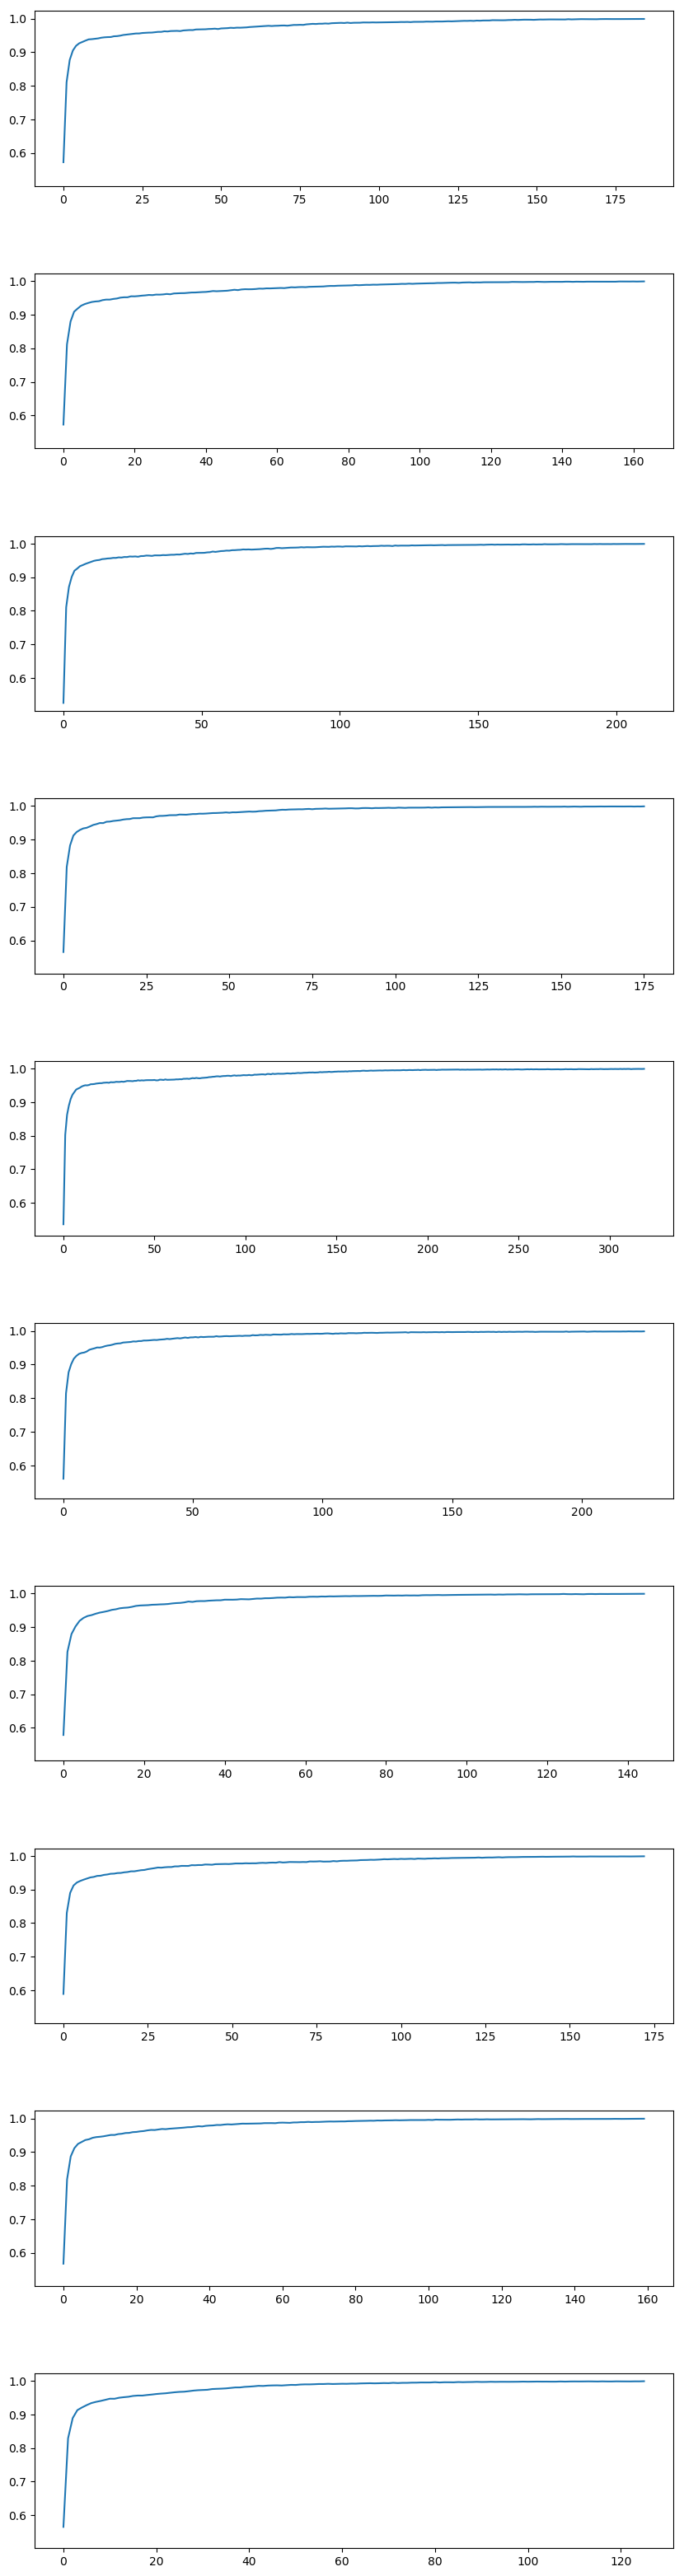

In [100]:
fig, axs = mpl.pyplot.subplots(len(histories), 1, sharex=False, sharey=True)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)

for i in range(0, len(histories)):
    axs[i].plot(histories[i].history['acc'])
#     axs[i].title = f'model accuracy ({i}-th fold)'
    axs[i].ylabel = 'tr. accuracy'
    axs[i].xlabel = 'tr. epoch'
fig.set_size_inches(10.0, 40.0)
mpl.pyplot.show(fig)

# mpl.pyplot.plot(history.history['acc'])
# mpl.pyplot.plot(history.history['val_acc'])
# mpl.pyplot.title('model accuracy')
# mpl.pyplot.ylabel('accuracy')
# mpl.pyplot.xlabel('epoch')
# mpl.pyplot.legend(['train', 'test'], loc='upper left')
# mpl.pyplot.show()
# # summarize history for loss
# mpl.pyplot.plot(history.history['loss'])
# mpl.pyplot.plot(history.history['val_loss'])
# mpl.pyplot.title('model loss')
# mpl.pyplot.ylabel('loss')
# mpl.pyplot.xlabel('epoch')
# mpl.pyplot.legend(['train', 'test'], loc='upper left')
# mpl.pyplot.show()

In [106]:
import datetime
best_model.save(f'balanced-fe-{datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}.h5')

2019-05-25-19-18-59


In [107]:
valset = pd.read_csv('poker-hand-testing+.csv')
print(valset.shape)
valset.head()

(999912, 33)


suit1   rank1   suit2   rank2   suit3   rank3   suit4   rank4   suit5  \
0      2       8       4       6       1      12       2      13       1   
1      1       7       4      13       4       9       1       9       1   
2      2      13       3       3       2      11       2       6       1   
3      4       3       2       4       4       9       2       8       1   
4      2       5       3       7       2      12       3       3       2   

    rank5  ...   n_7s   n_8s   n_9s   n_10s   n_jacks   n_queens   n_kings  \
0       8  ...      0      2      0       0         0          1         1   
1      10  ...      1      0      2       1         0          0         1   
2       4  ...      0      0      0       0         1          0         1   
3      11  ...      0      1      1       0         1          0         0   
4      11  ...      1      0      0       0         1          1         0   

    max_same_rank   longest_contigue_seq   class  
0               2                      2       1  
1               2                      2       1  
2               1                      2       0  
3               1                      2       0  
4               1                      2       0  

[5 rows x 33 columns]

In [108]:
XY_val = valset.values
X_val = X_scaler.transform(XY_val[:, :-1])
Y_val = XY_val[:, -1:]

In [109]:
Y = best_model.predict(X_val)

In [110]:
Y1 = Y_binariser.inverse_transform(Y)

In [111]:
metrics.f1_score(Y_val, Y1, average='weighted')

0.9870849847747227

In [112]:
pd.DataFrame(metrics.confusion_matrix(Y_val, Y1, labels=list(range(0, 10))))

0       1      2      3     4     5     6    7   8   9
0  500745       0      0      0   400     0     0    0   7  11
1       0  412076  10362     22     0     0     0    0   1   0
2       0    1973  45644      0     0     0     0    0   0   0
3       0       0      0  20959     0     0   162    0   0   0
4       0       0      0      0  3846     0     0    0  33   6
5       0       0      0      0     0  1984     0    0   6   6
6       0       0     15    344     0     0  1065    0   0   0
7       0       0      0     14     0     0     6  210   0   0
8       0       0      0      0     0     1     0    0  11   0
9       0       0      0      0     0     0     0    0   0   3